<a href="https://colab.research.google.com/github/erikjskie/ensemblemerge_manuscript/blob/main/Supplementary_Fig9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages("BiocManager")
BiocManager::install(c("ComplexHeatmap", "circlize"))
library(ComplexHeatmap)
library(circlize)
library(magrittr)
library(dplyr)
library(ggplot2)
library(tidyr)
library(tidyverse)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.2 (2021-11-01)

Installing package(s) 'BiocVersion', 'ComplexHeatmap', 'circlize'

also installing the dependencies ‘rjson’, ‘BiocGenerics’, ‘S4Vectors’, ‘iterators’, ‘GetoptLong’, ‘clue’, ‘GlobalOptions’, ‘png’, ‘IRanges’, ‘matrixStats’, ‘foreach’, ‘doParallel’, ‘shape’


Old packages: 'broom', 'fansi', 'gert', 'Rcpp', 'class', 'foreign', 'MASS',
  'nlme', 'nnet', 'spatial'

Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex hea

In [2]:
system("wget -x -c -nH https://s3.msi.umn.edu/skiex003/datasets/EnsembleMerge/fig9.csv")
dat = read.table(file = "skiex003/datasets/EnsembleMerge/fig9.csv", header = T, sep = ",") %>% select(score, score_method, method, Dataset, Datasets)
system("wget -x -c -nH https://s3.msi.umn.edu/skiex003/datasets/EnsembleMerge/scVI.csv")
scvi = read.table(file = "skiex003/datasets/EnsembleMerge/scVI.csv", header = T, sep = ",")
scvi$Dataset = recode_factor(scvi$Datasets, Dataset_1 = "Villani 2017", Dataset_2 = "Han 2018", Dataset_3 = "Chen 2020", Dataset_4 = "Hemberg Panc",
                                                                          Dataset_5 = "PBMC", Dataset_6 = "293t_Jurkat", Dataset_7 = "Hemberg Retina", Dataset_8 = "Saunders 2018", Dataset_9 = "HCA Blood",
                                                                          Dataset_10 = "Paul 2015", Dataset_11 = "Human/mouse Retina", Dataset_12 = "Zilionis 2019", Dataset_13 = "Shekhar 2016", Dataset_14 = "Nestorowa 2016",
                                                                          Dataset_15 = "Zheng 2017", Dataset_16 = "Polanski 2019", Dataset_17 = "HBDC", Dataset_18 = "Panc8")
scvi = scvi[,c("score", "score_method", "method", "Dataset", "Datasets")]
system("wget -x -c -nH https://s3.msi.umn.edu/skiex003/datasets/EnsembleMerge/fastMNN.csv")
mnn = read.table(file = "skiex003/datasets/EnsembleMerge/fastMNN.csv", header = T, sep = ",")
mnn$Dataset = recode_factor(mnn$Datasets, Dataset_1 = "Villani 2017", Dataset_2 = "Han 2018", Dataset_3 = "Chen 2020", Dataset_4 = "Hemberg Panc",
                                                                          Dataset_5 = "PBMC", Dataset_6 = "293t_Jurkat", Dataset_7 = "Hemberg Retina", Dataset_8 = "Saunders 2018", Dataset_9 = "HCA Blood",
                                                                          Dataset_10 = "Paul 2015", Dataset_11 = "Human/mouse Retina", Dataset_12 = "Zilionis 2019", Dataset_13 = "Shekhar 2016", Dataset_14 = "Nestorowa 2016",
                                                                          Dataset_15 = "Zheng 2017", Dataset_16 = "Polanski 2019", Dataset_17 = "HBDC", Dataset_18 = "Panc8")
mnn = mnn[,c("score", "score_method", "method", "Dataset", "Datasets")]
dat = rbind(dat, mnn)
dat = rbind(dat, scvi)


dat$Datasets = factor(dat$Datasets, levels = c("Dataset_1", "Dataset_2", "Dataset_3", "Dataset_4", #reorder datasets in ascending order
                                                                          "Dataset_5", "Dataset_6", "Dataset_7", "Dataset_8", "Dataset_9",
                                                                          "Dataset_10", "Dataset_11", "Dataset_12", "Dataset_13", "Dataset_14",
                                                                          "Dataset_15", "Dataset_16","Dataset_17","Dataset_18"))
dat$Dataset = recode_factor(dat$Datasets, Dataset_1 = "Villani 2017", Dataset_2 = "Han 2018", Dataset_3 = "Chen 2020", Dataset_4 = "Hemberg Panc",
                                                                          Dataset_5 = "PBMC", Dataset_6 = "293t_Jurkat", Dataset_7 = "Hemberg Retina", Dataset_8 = "Saunders 2018", Dataset_9 = "HCA Blood", # reassingn dataset names to manuscript names
                                                                          Dataset_10 = "Paul 2015", Dataset_11 = "Human/mouse Retina", Dataset_12 = "Zilionis 2019", Dataset_13 = "Shekhar 2016", Dataset_14 = "Nestorowa 2016",
                                                                          Dataset_15 = "Zheng 2017", Dataset_16 = "Polanski 2019", Dataset_17 = "HBDC",Dataset_18 = "Panc8")

uncorrected = dat %>% filter(method == "Uncorrected") # seperate baseline methods from results

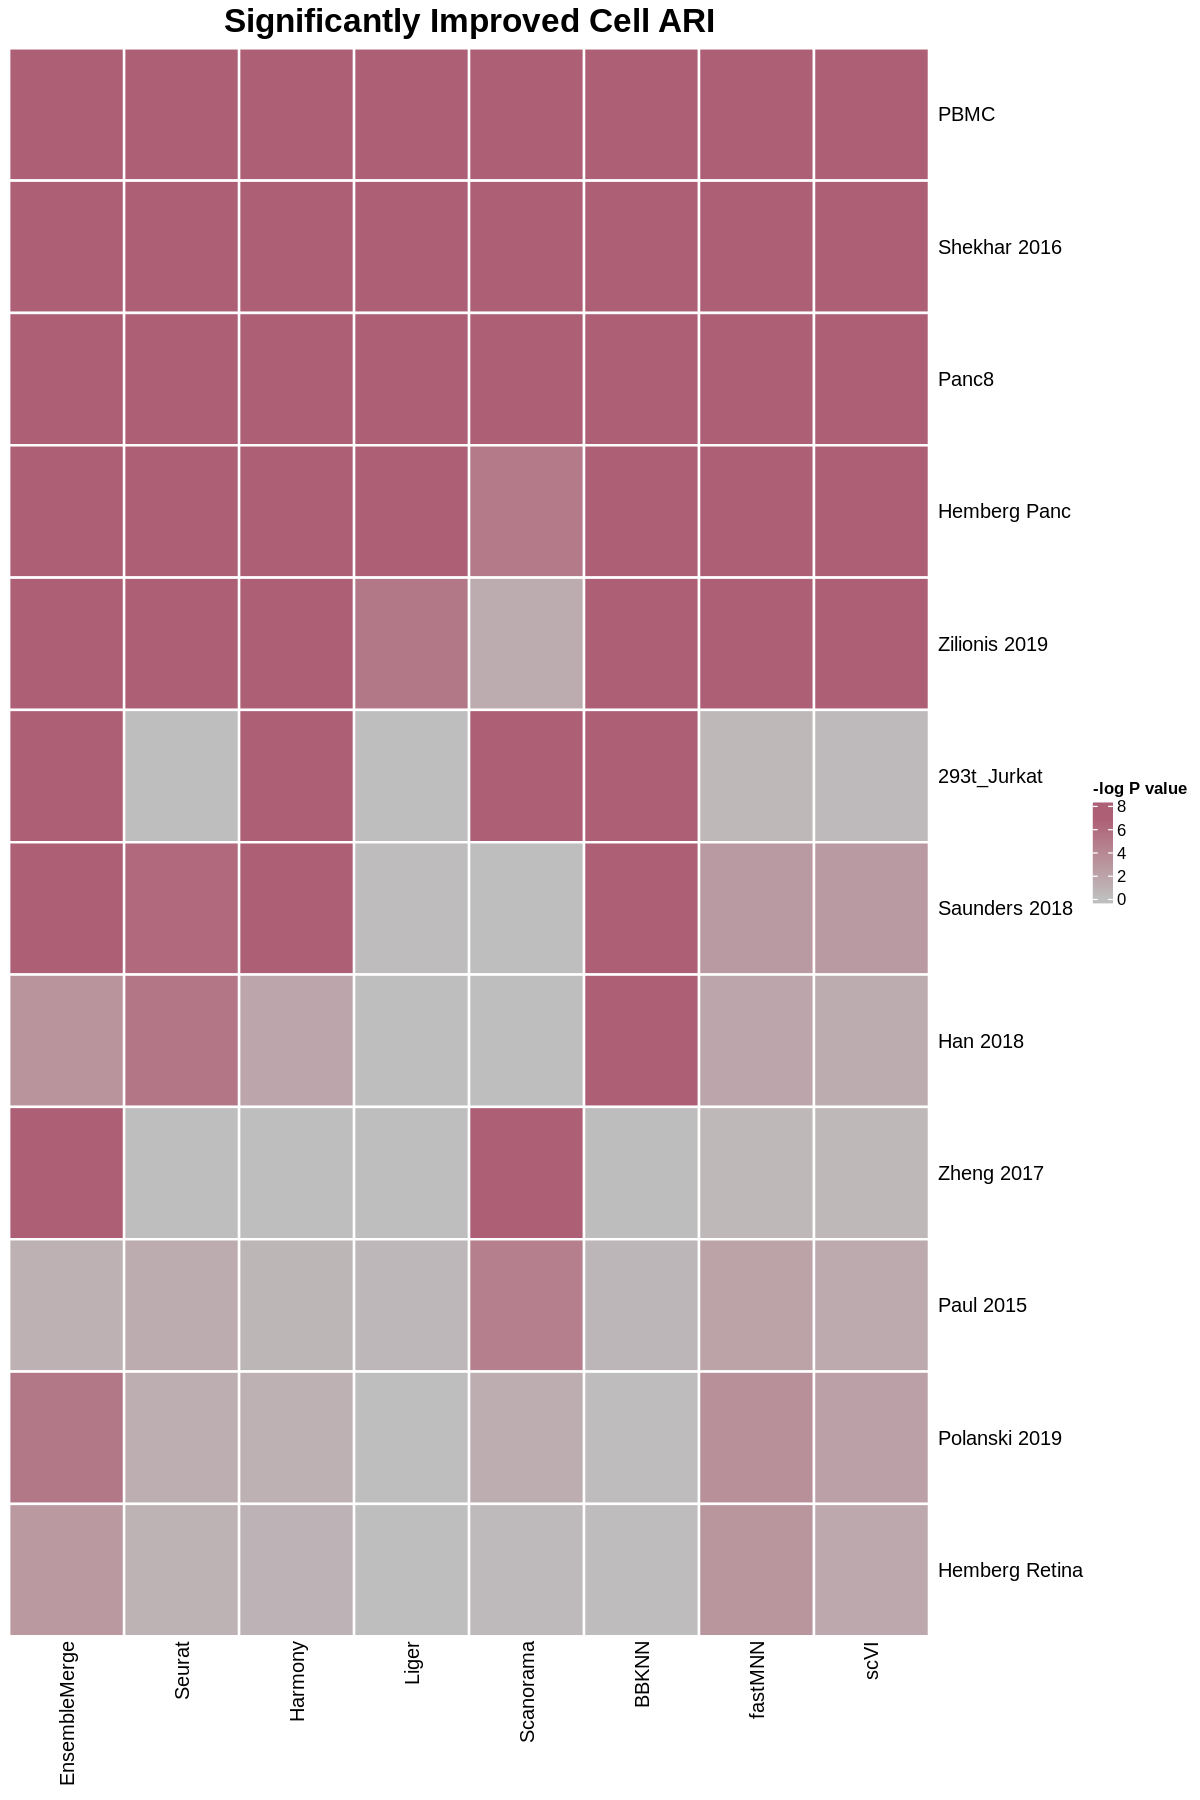

In [3]:
options(repr.plot.width = 10, repr.plot.height = 15)
oldw <- getOption("warn")
options(warn = -1)
mat = dat
mat %<>%
  distinct() %>%
  select(score, method, Dataset) %>% filter(method != "Uncorrected") %>%
  group_by(Dataset, method) %>% 
  mutate(p_value = (sum(abs(uncorrected$score[uncorrected$Dataset == Dataset]) >= abs(mat$score[mat$method == method & mat$Dataset == Dataset]))+1)/(length(uncorrected$score[uncorrected$Dataset == Dataset]))) %>% 
  ungroup() %>% 
  select(Dataset, method, p_value) %>% 
  distinct() %>%  
  filter(method != "Uncorrected" & !Dataset %in% c("HCA Blood", "Chen 2020", "HBDC", "Nestorowa 2016", "Villani 2017", "Human/mouse Retina")) %>% #remove baseline results and datasets with no significant results
  pivot_wider(names_from = method, values_from = p_value) %>% column_to_rownames(var = "Dataset") %>% 
  as.matrix()
mat = mat[,c("EnsembleMerge", "Seurat", "Harmony", "Liger", "Scanorama", "BBKNN", "fastMNN", "scVI")] # change rownames for figure
mat = -log(mat) #negative log scaling p value for interpretability

col_fun <- colorRamp2(quantile(mat, c(0,1)), c("gray", "#AD5F76"))
Heatmap(mat, column_title = "Significantly Improved Cell ARI",
        name = "-log P value",
        column_title_gp = gpar(fontsize = 20, fontface = "bold"),
        rect_gp = gpar(lwd = 2, col = "white"),
        show_column_dend = FALSE,
        show_row_dend = FALSE,
        cluster_rows = TRUE,
        cluster_columns = FALSE,
        col = col_fun,
        row_labels = rownames(mat)) +
  rowAnnotation(rn = anno_text(unique(rownames(mat))))
options(warn = oldw)

In [4]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] forcats_0.5.1         stringr_1.4.0         purrr_0.3.4          
 [4] readr_2.1.1           tibble_3.1.6          tidyverse_1.3.1      
 [7] tidyr_1.1.4           ggplot2_3.3.5         dplyr_1.0.7          
[10] magrittr_2.0.1        circlize_0.4.13 